## 1. Using Python BeautifulSoup to scrape Kompas Headlines

Scrape the headlines of the Kompas News website and try to build machine learning classifier from it.
The website will be scraped using python's BeautifulSoup package.

### Importing Libraries

We'll start by importing the necessary libraries as follows:

In [1]:
import pandas as pd
import numpy as np
import re
import time
from urllib.request import urlopen
from bs4 import BeautifulSoup

### Determining Pages to be Scraped

A sample URL that we're going to loop and scrape is the following https://indeks.kompas.com/?site=news&date=2020-01-24&page=. If we see on the actual website, the url changes for each page. In order to loop through all the pages to get the necessary dataset, we need to find out the number of pages, which is 26 pages.

List variables that will hold the scraped values for the columns we intend:

In [2]:
title=[]
category=[]

### Doing the actual scrape

We will now use a for loop and go through each page one by one to get our fields of interest as shown below.

In [3]:
for cp in np.arange(1,27):
    url = "https://indeks.kompas.com/?site=news&date=2020-01-24&page=" + str(cp)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    
    title.append([i.text for i in soup.find_all(class_='article__title article__title--medium')])
    category.append([i.text for i in soup.find_all(class_='article__subtitle article__subtitle--inline')])
    time.sleep(3)
    
print ("Done!")

Done!


The above code segment:

* Set the url to a variable
* Opened the url using urlopen
* Scraped the specified page and assigned it to soup variable
* Identified and extracted values for Title and Category by using their relevant class names. These class names were found using Developer Tools.

### Flattening List of Lists
Since the values we got are list of lists, they will now be flatted using the following code:

In [4]:
titleflat = [y for x in title for y in x]
categoryflat = [y for x in category for y in x]

### Making a Data Frame and Saving as CSV File

In [5]:
cdata = {"title":titleflat, "category":categoryflat}
df = pd.DataFrame(data = cdata)
df.to_csv("c:\\Users\\HP\\Desktop\\Projects\\Projects\\Vutura\\kompas24jan.csv", header=True, index=False)

### Reading CSV File

In [6]:
kompas = pd.read_csv('kompas24jan.csv')
kompas.shape

(376, 2)

In [7]:
kompas.head()

,title,category
0,[BERITA FOTO] Bumi Tak Pilih Kasih di Kuburan ...,Megapolitan
1,Apa Alasan Pemprov DKI Jakarta Pilih PT Bahana...,Megapolitan
2,Ma'ruf Amin Sebut Solusi Militer Tak Sepenuhny...,Regional
3,Harga Cabai di Tegal Meroket,Regional
4,"3 Peran Orangtua Didik Anak di Era ""Zaman Now""",Edukasi


# 2. Building News Categorization

In this section, we will apply NLP (Natural Language Processing) along with some supervised machine learning (sklearn) to build a News Categorization detector.

### Transforming collected data

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stop_factory = StopWordRemoverFactory().get_stop_words()  ## stop_word for Indonesian language

# Create a series to store the labels: y
y = kompas.category

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(kompas['title'], y, test_size=0.333, random_state=89)

### Vectorize the data

In [9]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words=stop_factory, max_df=0.9)

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

In [10]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_factory, max_df=0.9)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test.values)

### Training a multinomial naive Bayes model

In [11]:
# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: count_pred
count_pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: count_score
count_score = metrics.accuracy_score(y_test, count_pred)
print('NaiveBayes Count Score: ', count_score)

# Calculate the confusion matrix: count_cm
count_cm = metrics.confusion_matrix(y_test, count_pred, 
                                    labels=['Megapolitan', 'Regional', 'Edukasi', 'Nasional', 'Internasional'])

NaiveBayes Count Score:  0.8253968253968254


In [12]:
# Calculate the accuracy score and confusion matrix of Multinomial Naive Bayes classifier predictions trained on tfidf_train, 
# y_train and tested against tfidf_test and y_test

nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)
tfidf_pred = nb_classifier.predict(tfidf_test)
tfidf_score = metrics.accuracy_score(y_test, tfidf_pred)

print('NaiveBayes Tfidf Score: ', tfidf_score)

tfidf_cm = metrics.confusion_matrix(y_test, tfidf_pred, 
                                    labels=['Megapolitan', 'Regional', 'Edukasi', 'Nasional', 'Internasional'])

NaiveBayes Tfidf Score:  0.7936507936507936


### Evaluating model using a confusion matrix

Confusion matrix, without normalization
Confusion matrix, without normalization


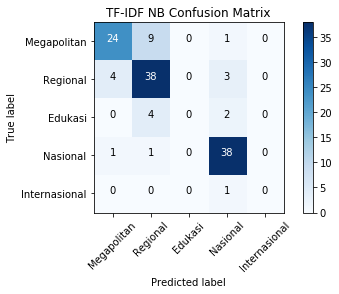

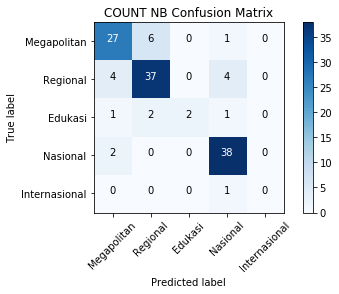

In [13]:
%matplotlib inline

from datasets.helper_functions import plot_confusion_matrix

# Calculate the confusion matrices for the tfidf_nb model and count_nb models
tfidf_cm = metrics.confusion_matrix(y_test, tfidf_pred, 
                                    labels=['Megapolitan', 'Regional', 'Edukasi', 'Nasional', 'Internasional'])
count_cm = metrics.confusion_matrix(y_test, count_pred, 
                                    labels=['Megapolitan', 'Regional', 'Edukasi', 'Nasional', 'Internasional'])

# Plot the tfidf_nb_cm confusion matrix
plot_confusion_matrix(tfidf_cm, classes=['Megapolitan', 'Regional', 'Edukasi', 'Nasional', 'Internasional'], 
                      title="TF-IDF NB Confusion Matrix")

# Plot the count_nb_cm confusion matrix without overwriting the first plot 
plot_confusion_matrix(count_cm, classes=['Megapolitan', 'Regional', 'Edukasi', 'Nasional', 'Internasional'], 
                      title='COUNT NB Confusion Matrix', figure=1)

### Trying another classifier: Linear SVC

LinearSVC Score:   0.849
Confusion matrix, without normalization


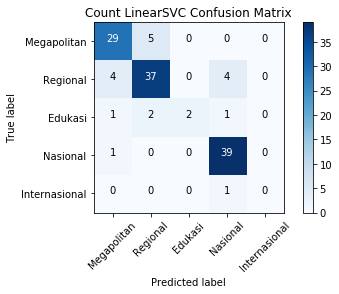

In [18]:
from sklearn.svm import LinearSVC

# Create a LinearSVC model
count_svc = LinearSVC()

count_svc.fit(count_train, y_train)

# Run predict on count test data to get predictions
count_svc_pred = count_svc.predict(count_test)

# Calculate accuracy using the metrics module
count_svc_score = metrics.accuracy_score(y_test, count_svc_pred)

print("LinearSVC Score:   %0.3f" % count_svc_score)

# Calculate the confusion matrices for the count_svc model
svc_cm = metrics.confusion_matrix(y_test, count_svc_pred, labels=['Megapolitan', 'Regional', 'Edukasi', 'Nasional', 'Internasional'])

plot_confusion_matrix(svc_cm, classes=['Megapolitan', 'Regional', 'Edukasi', 'Nasional', 'Internasional'], 
                      title="Count LinearSVC Confusion Matrix")

## Conclusion

Of the three models carried out, it was shown that the LinearSCV model classification produced a better prediction among the other multinomial Bayesian models.